In [1]:
import pygame
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import namedtuple
import matplotlib.pyplot as plt
from IPython.display import clear_output

# 화면 크기 설정
WIDTH = 800
HEIGHT = 600

# 색깔 정의
WHITE = (255, 255, 255)
BLACK = (0, 0, 0)
BLUE = (0, 0, 255)
YELLOW = (255, 255, 0)

# 패들 설정
PADDLE_WIDTH = 100
PADDLE_HEIGHT = 20
PADDLE_SPEED = 10

# 공 설정
BALL_RADIUS = 10
BALL_SPEED_X = 5
BALL_SPEED_Y = 5

# 벽돌 설정
BRICK_WIDTH = 100
BRICK_HEIGHT = 30
BRICK_ROWS = 5
BRICK_COLS = 8
BRICK_SPACING = 10

# 에이전트 설정
GAMMA = 0.99  # 할인 계수
EPS_START = 0.9  # 랜덤 행동 시작 확률
EPS_END = 0.05  # 랜덤 행동 최종 확률
EPS_DECAY = 200  # 랜덤 행동 확률 감소 속도
TARGET_UPDATE = 10  # 목표 네트워크 업데이트 주기
BATCH_SIZE = 128  # 배치 크기

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# DQN 네트워크 구현
class DQN(nn.Module):
    def __init__(self):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(6, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 3)  # 3가지 행동: 왼쪽, 가만히, 오른쪽

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Replay Memory 정의
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Transition 저장"""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.tensor([s for s in batch.next_state if s is not None], device=device, dtype=torch.float32)

    state_batch = torch.tensor(batch.state, device=device, dtype=torch.float32)
    action_batch = torch.tensor(batch.action, device=device, dtype=torch.long).unsqueeze(1)
    reward_batch = torch.tensor(batch.reward, device=device, dtype=torch.float32)

    state_action_values = policy_net(state_batch).gather(1, action_batch)

    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

# 게임 환경 클래스
class BreakoutGame:
    def __init__(self):
        pygame.init()
        self.screen = pygame.display.set_mode((WIDTH, HEIGHT))
        pygame.display.set_caption("Breakout")
        self.clock = pygame.time.Clock()
        self.font = pygame.font.Font(None, 36)
        self.score = 0
        self.reset()

    def reset(self):
        self.paddle = pygame.Rect((WIDTH - PADDLE_WIDTH) // 2, HEIGHT - PADDLE_HEIGHT - 10, PADDLE_WIDTH, PADDLE_HEIGHT)
        self.ball = pygame.Rect(WIDTH // 2 - BALL_RADIUS, HEIGHT // 2 - BALL_RADIUS, BALL_RADIUS * 2, BALL_RADIUS * 2)
        self.bricks = [pygame.Rect(j * (BRICK_WIDTH + BRICK_SPACING), i * (BRICK_HEIGHT + BRICK_SPACING) + 50, BRICK_WIDTH, BRICK_HEIGHT)
                       for i in range(BRICK_ROWS) for j in range(BRICK_COLS)]
        self.ball_speed_x = BALL_SPEED_X * random.choice([1, -1])
        self.ball_speed_y = BALL_SPEED_Y * 1
        return self.get_state()

    def get_state(self):
        return np.array([(self.ball.left - self.paddle.left) / WIDTH, self.ball.top / HEIGHT,
                         self.ball_speed_x / BALL_SPEED_X, self.ball_speed_y / BALL_SPEED_Y,
                         self.paddle.left / WIDTH, self.paddle.right / WIDTH], dtype=np.float32)

    def step(self, action):
        if action == 0:
            self.paddle.x -= PADDLE_SPEED
        elif action == 2:
            self.paddle.x += PADDLE_SPEED

        self.ball.x += self.ball_speed_x
        self.ball.y += self.ball_speed_y

        if self.ball.left <= 0 or self.ball.right >= WIDTH:
            self.ball_speed_x *= -1
        if self.ball.top <= 0:
            self.ball_speed_y *= -1

        if self.ball.colliderect(self.paddle):
            self.ball_speed_y *= -1
            self.score += 50

        for brick in self.bricks[:]:
            if self.ball.colliderect(brick):
                self.bricks.remove(brick)
                self.ball_speed_y *= -1
                self.score += 50

        if self.ball.bottom >= HEIGHT:
            self.score -= 1
            return True, self.score, self.reset()

        return False, self.score, self.get_state()

    def render(self):
        self.screen.fill(BLACK)
        pygame.draw.rect(self.screen, BLUE, self.paddle)
        pygame.draw.circle(self.screen, YELLOW, self.ball.center, BALL_RADIUS)
        for brick in self.bricks:
            pygame.draw.rect(self.screen, WHITE, brick)
        pygame.display.flip()

    def close(self):
        pygame.quit()

def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * np.exp(-1.0 * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(torch.tensor(state).unsqueeze(0).to(device)).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(3)]], device=device, dtype=torch.long)

# 학습 준비
policy_net = DQN().to(device)
target_net = DQN().to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(10000)

steps_done = 0

# 학습 및 게임 실행
env = BreakoutGame()
num_episodes = 10000
episode_scores = []  # 각 에피소드의 스코어를 기록할 리스트


pygame 2.5.2 (SDL 2.28.3, Python 3.10.14)
Hello from the pygame community. https://www.pygame.org/contribute.html


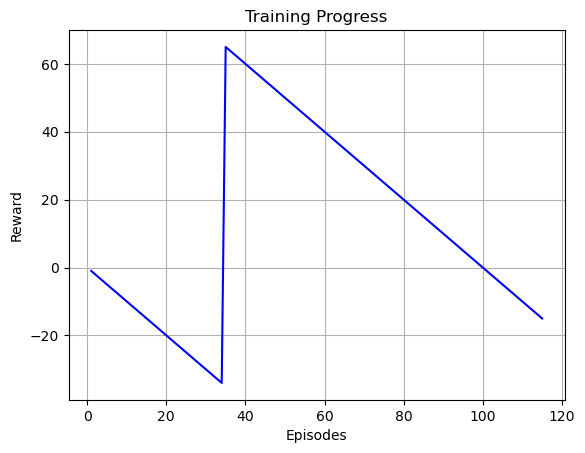

In [2]:

for i_episode in range(num_episodes):
    state = env.reset()
    episode_score = 0  # 에피소드 스코어를 기록할 변수
    prev_score = 0  # 이전 스코어를 기록할 변수
    for t in range(10000):  # 최대 에피소드 길이
        action = select_action(state)
        done, score, next_state = env.step(action.item())
        reward = score - prev_score  # 이전 스코어와 현재 스코어의 차이를 보상으로 사용
        reward = score
        episode_score = reward  # 에피소드 스코어 업데이트
        prev_score = score  # 이전 스코어 업데이트
        memory.push(state, action, next_state, reward)
        state = next_state
        optimize_model()
        if done:
            break
        # 게임 화면 업데이트 및 이벤트 처리
        env.render()
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                env.close()
                pygame.quit()
                quit()

    # 각 에피소드의 스코어를 기록
    episode_scores.append(score)

    # 매 에피소드마다 스코어 그래프 업데이트
    clear_output()
    plt.plot(range(1, i_episode+2), episode_scores, color='blue')
    plt.xlabel('Episodes')
    plt.ylabel('Reward')
    plt.title('Training Progress')
    plt.grid(True)
    plt.show()

# 학습이 끝난 후에 게임 창을 닫습니다.
env.close()